# Object oriented programming (OOP): Agent based infection model

## Libraries and settings

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import enum
from enum import Enum

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/workspaces/scientific_programming/Week_09/exercises


## Building an agent-based model

### State and MyAgent classes

We then create the Agent class. It has three possible states and transitions between them through the simulation. At each step the agent will move and then can carry out any operation such as infecting another agent in the same cell in the grid if the other agent is susceptible. The agent can also recover over time.

In [2]:
class State(enum.IntEnum):
    """ A class to track the state of the model."""
    
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

class MyAgent(Agent):
    """ An agent in an epidemic model."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = self.random.normalvariate(20,40)        
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0

    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""

        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED

    def contact(self):
        """Find close contacts and infect"""

        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = model.get_recovery_time()

    def step(self):
        self.status()
        self.move()
        self.contact()

### InfectionModel class

We first make a Model class defining a grid, scheduler for tracking the order of agents being activated in time. Time periods are represented as steps and the agents can all move once in each step. Then the agent will decide if it can infect another according to where it is. The DataCollector class keeps track of agent information through the simulation. The grid is a MultiGrid class, which let more than one agent occupy a cell at once.

In [3]:
class InfectionModel(Model):
    """A model for infection spread."""

    def __init__(self, N=10, width=10, height=10, ptrans=0.5,
                 death_rate=0.02, recovery_days=21, recovery_sd=7):

        self.num_agents = N
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        
        # Create agents
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
            # Make some agents infected at start
            infected = np.random.choice([0,1], p=[0.98,0.02])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()

        self.datacollector = DataCollector(          
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

## Setup model parameters and run the model

In [4]:
# Settings for number of steps and population size
steps = 500
pop = 500

# Initialize and run the model
model = InfectionModel(pop, 20, 20, ptrans=0.5)
for i in range(steps):
    model.step()

# Agent state table
agent_state = model.datacollector.get_agent_vars_dataframe()
print(agent_state)


              State
Step AgentID       
0    0            1
     1            0
     2            0
     3            0
     4            0
...             ...
499  491          2
     492          2
     493          2
     496          2
     498          2

[173469 rows x 1 columns]


## View model states data

In [5]:
def get_column_data(model):
    """Pivot the model dataframe to get states count at each step."""

    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),
                       index='Step',
                       columns='State',
                       aggfunc=np.size,
                       fill_value=0)    
    labels = ['Susceptible','Infected','Removed']
    X.columns = labels[:len(X.columns)]
    return X

df = get_column_data(model)
df

,Susceptible,Infected,Removed
Step,,,
0,495,5,0
1,488,12,0
2,484,16,0
3,476,24,0
4,474,26,0
...,...,...,...
495,0,0,340
496,0,0,340
497,0,0,340


## Plot model states

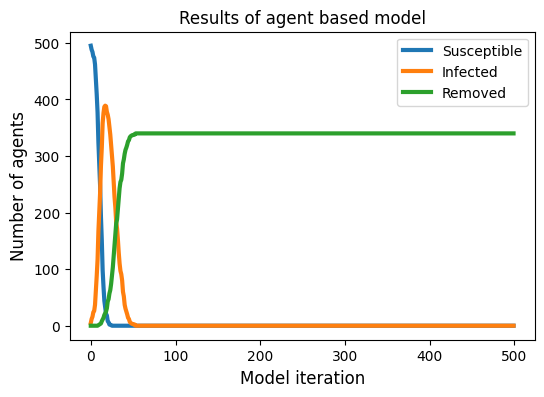

In [6]:
# Plot states
plt.figure(figsize=(6,4))
plt.plot(df.index, 
         df.Susceptible, 
         label = "Susceptible", 
         linestyle="-", 
         linewidth=3)
plt.plot(df.index, 
         df.Infected, 
         label = "Infected", 
         linestyle="-", 
         linewidth=3)
plt.plot(df.index, 
         df.Removed, 
         label = "Removed", 
         linestyle="-", 
         linewidth=3)
plt.title('Results of agent based model', fontsize=12)
plt.xlabel('Model iteration', fontsize=12)
plt.ylabel('Number of agents', fontsize=12)
plt.legend()
plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [ ]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')